In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
!pip install mecab-python3

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import MeCab

import time
import re
import os
import io
from tqdm import tqdm
import random

### 데이터 다운로드

In [4]:
path_to_dir = os.getenv('HOME') + "/aiffel/s2s_translation/data/"

path_to_train_kor = path_to_dir + "korean-english-park.train.ko"
path_to_train_eng = path_to_dir + "korean-english-park.train.en"

path_to_test_kor = path_to_dir + "korean-english-park.test.ko"
path_to_test_eng = path_to_dir + "korean-english-park.test.en"

In [5]:
def read_data(path_to_data):
    with open(path_to_data, "r") as f:
        data = f.read().splitlines()
    return data

In [6]:
src_train = read_data(path_to_train_kor)
tgt_train = read_data(path_to_train_eng)

src_test = read_data(path_to_test_kor)
tgt_test = read_data(path_to_test_eng)

In [7]:
print(len(src_train))
print(len(src_test))

94123
2000


In [8]:
# 데이터 중복 제거
unique_pairs = set(zip(src_train, tgt_train))
corpus_train = list(unique_pairs)

### 데이터 전처리

In [9]:
def preprocess_eng(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'
    
    return sentence

In [10]:
def preprocess_kor(sentence):
    sentence = sentence.strip()

    # 문장부호 앞뒤로 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 연속된 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)

    # 한글, 문장부호(?.!,)만 남기고 나머지는 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣ?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [11]:
enc_corpus_train = []
dec_corpus_train = []

for pair in corpus_train:
    kor, eng = pair[0], pair[1]
    if len(kor) <= 60 and len(eng) <= 60:
        enc_corpus_train.append(preprocess_kor(kor))
        dec_corpus_train.append(preprocess_eng(eng))

print("Korean:", enc_corpus_train[1972])
print("English:", dec_corpus_train[1972])

print(len(enc_corpus_train))

Korean: 이 은행의 가장 중요한 임무는 인플레이션 압박을 완화하는 것이다 .
English: <start> the bank s primary mission is to combat inflation . <end>
8058


In [12]:
def tokenize_eng(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
def tokenize_kor(corpus):
    mecab = MeCab.Tagger()
    
    # Tokenizing each sentence
    tokenized_corpus = []
    for sentence in corpus:
        parsed_text = mecab.parse(sentence)  # Parse the sentence
        tokens = [line.split("\t")[0] for line in parsed_text.split("\n") if line and "\t" in line]  # Extract words
        tokenized_corpus.append(tokens)

    # Keras Tokenizer to convert tokens to integers
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(tokenized_corpus)

    tensor = tokenizer.texts_to_sequences(tokenized_corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [14]:
# 토큰화하기
enc_input, enc_tokenizer = tokenize_kor(enc_corpus_train)
dec_input, dec_tokenizer = tokenize_eng(dec_corpus_train)

# train_test_split을 활용해서 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val = train_test_split(enc_input, test_size=0.2)
dec_train, dec_val = train_test_split(dec_input, test_size=0.2)

In [15]:
print(len(enc_val))

1612


### 모델 설계

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(hidden_size)
        self.w_enc = tf.keras.layers.Dense(hidden_size)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)   # shape : (batch, length, hidden_size)
        h_dec = tf.expand_dims(h_dec, 1)    # shape : (batch, hidden_size) -> (batch, 1, hidden_size)
        h_dec = self.w_dec(h_dec)   

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
BATCH_SIZE = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 60

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 60, 512)
Decoder Output: (128, 1, 9309)
Decoder Hidden State: (128, 512)
Attention: (128, 60, 1)


### 학습 & 추론

In [26]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction='none')

def loss_function(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0)
    loss = loss_object(y_true, y_pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    batch_size = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * batch_size, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [28]:
# Define eval_step
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process with validation

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 22.73it/s, Test Loss 2.7928]


### 번역 결과 확인

Input: 비록 그 위협은 적지만 , 그 잠재적인 영향력은 가히 파괴적인 것이다
Predicted translation: the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_96/3434245412.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_96/3434245412.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


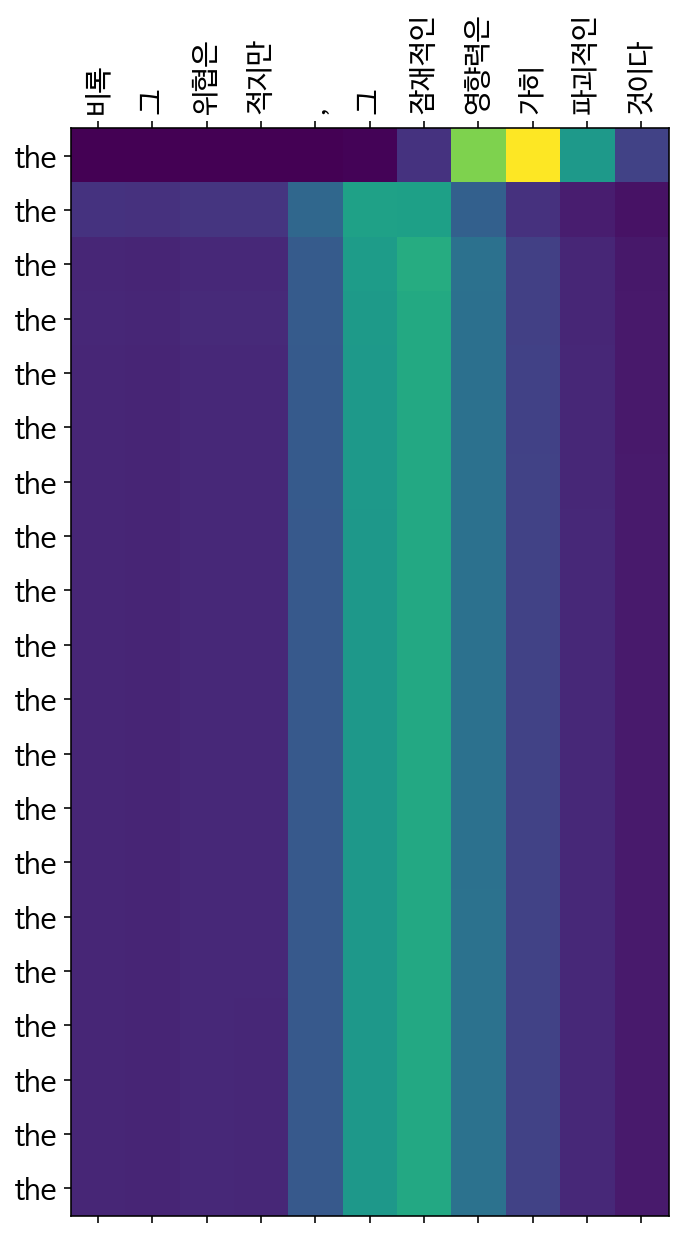

In [29]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_kor(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention[t] = attention_weights.numpy()

        # Ensure to take the argmax for batch_size=1 and handle it correctly for larger batches
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0], axis=-1).numpy()  # Shape: (batch_size,)
        
        # If batch_size=1, just take the first element
        if predicted_id.shape[0] == 1:
            predicted_id = predicted_id[0]
        else:
            # Handle the batch case (take first prediction for simplicity)
            predicted_id = predicted_id[0]

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention



def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("비록 그 위협은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다", encoder, decoder)